In [25]:
import matplotlib.testing.exceptions
from SurfaceTopography.Generation import fourier_synthesis
from matplotlib import pyplot as plt

from Adhesion.Interactions import RepulsiveExponential
from ContactMechanics import FreeFFTElasticHalfSpace, PeriodicFFTElasticHalfSpace
from Adhesion.System import BoundedSmoothContactSystem, SmoothContactSystem
import scipy.interpolate
import muFFT
from ContactMechanics.Tools.Logger import Logger
import time
import os
import numpy as np

np.random.seed(0)

Es = 1
hprms=0.1

0.0
############# PRECONDITIONED LBFGS RUNNING #######################


/Users/antoines/Adhesion/Adhesion/Interactions/Exponential.py:218: RuntimeWarning: overflow encountered in exp
  V_rep = gam_rep * np.exp(g_rep)


CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
1474
################## LBFGS REAL RUNNING ############################
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
4536
################## LBFGS HC-FOURIER RUNNING ############################
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
6357


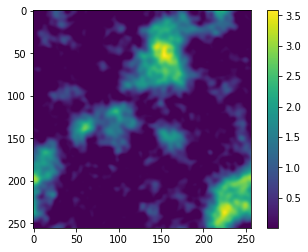

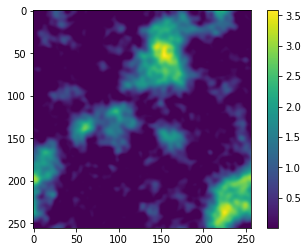

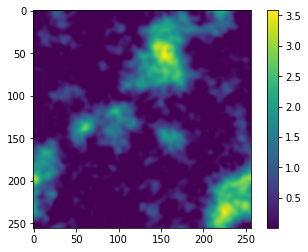

In [61]:
gtol = 1e-5
n = 128

w = 0.05
interaction_range = 1

topography = fourier_synthesis(
    (n, n),
    (n, n),
    hurst=0.8,
    rms_slope=0.1,
    short_cutoff=8,
    long_cutoff=n/2,
)
topography = topography.scale(hprms / topography.rms_gradient()).squeeze()
topography._heights = topography.heights() - np.max(topography.heights())

print(np.max(topography.heights()))

substrate = PeriodicFFTElasticHalfSpace(
    (n,n), Es, physical_sizes=(n,n),
    fft='serial')

interaction = RepulsiveExponential(100 * w, 0.001 * interaction_range, w, interaction_range).linearize_core(hardness=1000)

system = SmoothContactSystem(substrate, interaction, topography)

# TODO: This should probably end up as a method of the system
def fix_mw_sol(x):

    var = x.copy()
    K = np.sqrt(system.stiffness_k.reshape(np.shape(x)) * system.area_per_pt)
    _fourier_sol_mw = var / K
    fourier_sol_MW = fix_fourier_sol(_fourier_sol_mw)
    return fourier_sol_MW

def fix_fourier_sol(x):
    var = x.copy()
    fourier_buffer.array()[...] = var.reshape(system.nb_grid_pts)
    engine.ihcfft(fourier_buffer,real_buffer)
    real_sol = real_buffer.array()[...].copy()*engine.normalisation
    return real_sol


max_stress = np.max(abs(system.interaction.max_tensile))
topography = system.surface
nx, ny = system.nb_grid_pts
sx, sy = topography.physical_sizes


typical_stress_rep = hprms * Es
typical_stress_adh = abs(system.interaction.max_tensile) #w / system.interaction.rho
typical_stress = max(typical_stress_rep, typical_stress_adh)

gtol_per_pixel = gtol * topography.area_per_pt #* typical_stress

offset_temp = 1 * system.surface.rms_height_from_area()

init_disp = np.zeros(system.substrate.nb_subdomain_grid_pts)

engine = muFFT.FFT(system.substrate.nb_grid_pts, fft='fftw',
                   allow_temporary_buffer=False,
                   allow_destroy_input=True)

real_buffer = engine.register_halfcomplex_field("real-space", 1)
fourier_buffer = engine.register_halfcomplex_field("fourier-space", 1)
real_buffer.array()[...] = init_disp
engine.hcfft(real_buffer, fourier_buffer)
k_float_disp = fourier_buffer.array()[...].copy()
k_float_disp_mw = k_float_disp * np.sqrt(system.stiffness_k)



print('############# PRECONDITIONED LBFGS RUNNING #######################')

sol = scipy.optimize.minimize(
    system.preconditioned_objective(offset_temp,gradient=True,
                           logger=Logger("evaluations_mwlbfgs.log")),
x0=k_float_disp_mw,
method='L-BFGS-B', jac=True, bounds=None,
options=dict(gtol=gtol_per_pixel,
             ftol=0, maxcor=3,
             maxiter=100000,
             maxfun=300000,
             ),
            )

print(sol.message)
print(sol.nit)
#assert sol.success

#_dump(system, offset_temp, sol)

disps = fix_mw_sol(sol.x)

gap = system.compute_gap(disps, offset_temp)
plt.figure()
plt.colorbar(plt.imshow(gap), label="gap")

print('################## LBFGS REAL RUNNING ############################')

sol = scipy.optimize.minimize(system.objective(offset_temp, gradient=True,
                                logger=Logger("evaluations_lbfgs.log")),
    x0=init_disp,
    method='L-BFGS-B', jac=True, bounds=None,
    options=dict(gtol=gtol_per_pixel,
                 ftol=0, maxcor=3,
                 maxiter=100000,
                 maxfun=300000,
                 ),
)

print(sol.message)
print(sol.nit)
#assert sol.success

#_dump_lbfgs(system, offset_temp, sol)
disps = sol.x.reshape((n,n))

gap = system.compute_gap(disps, offset_temp)
plt.figure()
plt.colorbar(plt.imshow(gap))

print('################## LBFGS HC-FOURIER RUNNING ############################')

sol = scipy.optimize.minimize(system.objective_k_float(offset_temp,
                                                       gradient=True,
                        logger=Logger("evaluations_lbfgs_fourier.log")),
                              x0=k_float_disp,
                              method='L-BFGS-B', jac=True, bounds=None,
                              options=dict(gtol=gtol_per_pixel,
                                           ftol=0, maxcor=3,
                                           maxiter=100000,
                                           maxfun=300000,
                                           ),
                              )

print(sol.message)
print(sol.nit)

#assert sol.success
disps = fix_fourier_sol(sol.x)

gap = system.compute_gap(disps, offset_temp)
plt.figure()
plt.colorbar(plt.imshow(gap))

Text(0.5, 0, 'x')

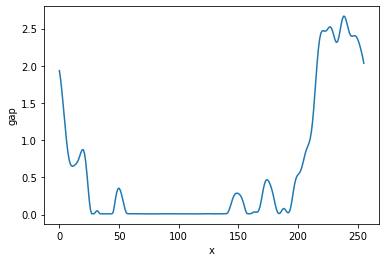

In [62]:
fig, ax = plt.subplots()

# find the maximum
#ixs = np.argmax(topography.heights(), axis =0)
#iy = np.argmax(topography.heights()[ixs, range(len(ixs))])
#ix = ixs[iy]
ix, iy =  np.unravel_index(topography.heights().argmax(), topography.nb_grid_pts)
#plt.colorbar(ax.pcolormesh(topography.heights().T,))
#ax.plot(ix, iy, "+r")

ax.plot(gap[ix, :])
ax.set_ylabel("gap")
ax.set_xlabel("x")

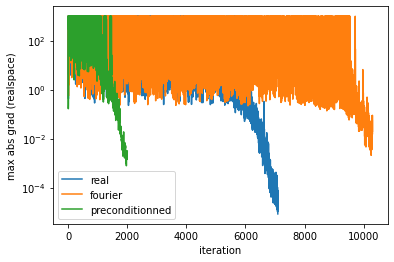

In [63]:

fig, ax = plt.subplots()


data_real = np.loadtxt("evaluations_lbfgs.log", comments="#")
ax.plot(data_real[:,1], label="real")

data_fourier = np.loadtxt("evaluations_lbfgs_fourier.log", comments="#")
ax.plot(data_fourier[:,-1], label="fourier")




data_precond = np.loadtxt("evaluations_mwlbfgs.log", comments="#")
ax.plot(data_precond[:,-1], label="preconditionned")



ax.set_xlabel("iteration")
ax.set_ylabel("max abs grad (realspace)")
ax.set_yscale("log")

ax.legend()

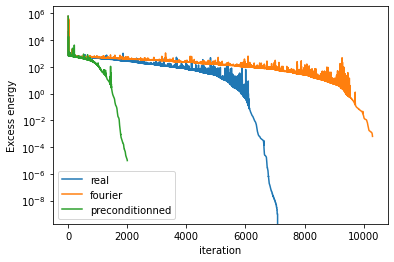

In [64]:
fig, ax = plt.subplots()



final_energy = data_real[-1,0]
ax.plot(data_real[:,0] - final_energy, label="real")

ax.plot(data_fourier[:,0] - final_energy, label="fourier")

ax.plot(data_precond[:,0] - final_energy, label="preconditionned")

ax.set_xlabel("iteration")
ax.set_ylabel("Excess energy")
ax.set_yscale("log")

ax.legend()